#Tutorial on EMA Workbench: Part 1
Prepared by Jayendran V (IEOR, IIT Bombay)

##About EMA workbench
The Exploratory Modeling and Analysis (EMA) workbench is a collection of open-source tools to help with decision making under deep uncertainty and robust decision making developed by Delft University, The Netherlands.   Documentation on using the EMA workbenchcan be found at [EMA Workbench Documentation](https://emaworkbench.readthedocs.io/en/latest/) site. The source codes and other samples is available via [GitHub](https://github.com/quaquel/EMAworkbench).

## Tutorial Part 1
Part l is designed to teach you the basic capabilities and steps in using EMA: define the EMA wrapper for the simulation by specifying the parameter uncertainties; perform experiments and visualisation of results.  
We will be using SEIR model of infectious diseases as an example.

## SEIR model
A  basic model for the spread of a disease is the Susceptible, Exposed, Infected, Recovered (SEIR) model. This model splits a population into four groups.

The SEIR model uses a system of ODE's to describe how these four groups change over time. The model uses only the contact ratio $\beta$, the average incubation time $1/\alpha$ and the mean recovery time $1/\gamma$.

Refer to the SEIR.ipynb for details about SEIR model.


In [ ]:
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint


# The SEIR differential equations.
def SEIRmodel(y, t, N, beta, alpha, gamma):
  S, E, I, R = y
  dS_dt = -beta*S*I/N
  dE_dt = beta*S*I/N - alpha*E
  dI_dt = alpha*E - gamma*I
  dR_dt = gamma*I
  return dS_dt, dE_dt, dI_dt, dR_dt

#
# The SEIRsim is the simulation subroutine based on odeint
# This inturn calls the SEIRmodel function
# Note that total population is taken as N=1 always, with a very small fraction for I0
#
def SEIRsim(beta = 0.25,    # the effective contact+infectivity rate
           alpha = 1./4,    # rate of showing symptoms
           gamma = 1./10,   # the mean recovery rate
           ):
  #Initial conditions
  N = 1 #Total Population taken as 1
  I0, E0, R0 = 10**-6, 0, 0  #10^-6 is similar to saying 1 in a million has been infected. 
  S0 = N - I0 - R0 - E0
  # Initial conditions vector
  y0 = S0, E0, I0, R0

  #timepoints
  t = np.linspace(0, 200, 200)

  # Integrate/Simulate the SIR equations over the time grid, t.
  eqn = odeint(SEIRmodel, y0, t, args=(N, beta, alpha, gamma))

  # Post processing
  S, E, I, R = eqn.T
  Rinf = R[-1] #This is the final value of Rinf
  
  #Return the SEIR timeseries, R_inf
  return S, E, I, R, Rinf

In [ ]:
# Libraries required need to be installed 
# if you are using Google Colab this has to be installed each time you run the page
# The -q switch makes it 'quiet' (less verbose output)
# 
!pip -q install ema_workbench
# and other dependencies
#!pip -q install altair
#!pip -q install ipyparallel
#!pip -q install SALib
#!pip -q install platypus-opt
#!pip -q install pydot

     |████████████████████████████████| 23.7 MB 1.2 kB/s 


##Connecting the SEIR model with the workbench
Let's connect this simple model to the EMA workbench. We make the following assumptions

$\beta$, $\alpha$ and $\gamma$ are uncertain. We assume that $\beta$ is somewhere between 0.15 and 0.4, $\alpha$ is between 1/7 to 1/3, while $\gamma$ is somewhere between 1/25 to 1/10.
The outcomes of interest are $S(t)$, $E(t)$, $I(t)$, and $R(t)$ over time, along with the $Rinf$.

To connect the model to the workbench, we need to do at least 3 things:

**Instantiate a model class:** the workbench comes with a variety of model classes for making it easy to connect with existing simulation packages such as Vensim, PySD, Simio, or Netlogo. Since we have a model implemented in Python, we can use the most basic Model class.

**Specify the uncertain parameters (and/or decision levers):** Note below how the name of the parameters matched the name of the keyword arguments of the SEIR_model function. The workbench makes a distinction between RealParameters, IntegerParameters, BinaryParameters, and CategoricalParameters. For this example, our parameters $\beta$, $\alpha$, and $\gamma$ have a continuous range so we use RealParameters

**Specify the outcomes of interest:** the workbench makes a distinction between TimeSeriesOutcomes and ScalarOutcomes. $S$, $E$, $I$, and $R$ are time series, so we use TimeSeriesOutcomes.   $Rinf$ are single values per combination, so we use ScalarOutcomes.

In [ ]:
from ema_workbench import (Model, RealParameter, ScalarOutcome, TimeSeriesOutcome)

mymodel = Model('SEIRsim', function=SEIRsim)  # instantiate the model

# specify uncertainties
mymodel.uncertainties = [RealParameter("beta", 0.15, 0.4), 
                       RealParameter("alpha", 1./7, 1./3),
                       RealParameter("gamma", 1./25, 1./10)]

# specify outcomes
mymodel.outcomes = [TimeSeriesOutcome('S'),
                    TimeSeriesOutcome('E'),
                    TimeSeriesOutcome('I'),
                    TimeSeriesOutcome('R'),
                  ScalarOutcome('Rinf')]


/usr/local/lib/python3.7/dist-packages/ema_workbench/em_framework/evaluators.py:22: UserWarning: ipyparallel not installed - IpyparalleEvaluator not available
  'ipyparallel not installed - IpyparalleEvaluator not available')
/usr/local/lib/python3.7/dist-packages/ema_workbench/em_framework/optimization.py:48: ImportWarning: platypus based optimization not available
  warnings.warn("platypus based optimization not available", ImportWarning)


The code above is a minimum working example of how to connect a model, the SIR_model function in this case, to the ema workbech. Even very large and complex cases will mimic this structure.

## Running the model with the workbench
The next step is to run the model. For this we use the `perform_experiments` method. The workbench by default will use a latin hypercupe sampler to generate points in the parameter space defined by the uncertainties and/or levers. The uncertainties jointly span the uncertainty space. The levers (not used in this example) span the lever space. A point in uncertainty space is a scenario. A point in lever space is a policy. The combination of a scenario and a policy (where either might be None) is an experiment.

###A few remarks on this

* The workbench assumes uniform distributions. 
* The workbench comes with a wide range of alternative samplers, some of which we will use later in the course
* The workbench offers support for taking advantage of the fact that many modern computers have multiple cores. (not using it yet)
* The workbench treats sampling in the uncertainty space and the lever space separately. It will always execute a full factorial over the combination of the lever space and the uncertainty space.
Let's run the model for 200 scenarios.

In [ ]:
#Run the model using EMA for 200 scenarios
from ema_workbench import (ema_logging, perform_experiments)

ema_logging.log_to_stderr(ema_logging.INFO)

results = perform_experiments(mymodel, scenarios=200)

[MainProcess/INFO] performing 200 scenarios * 1 policies * 1 model(s) = 200 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 20 cases completed
[MainProcess/INFO] 40 cases completed
[MainProcess/INFO] 60 cases completed
[MainProcess/INFO] 80 cases completed
[MainProcess/INFO] 100 cases completed
[MainProcess/INFO] 120 cases completed
[MainProcess/INFO] 140 cases completed
[MainProcess/INFO] 160 cases completed
[MainProcess/INFO] 180 cases completed
[MainProcess/INFO] 200 cases completed
[MainProcess/INFO] experiments finished


##Visualize the results
Now that we have run the model 200 times, we can visualize the results. The workbench comes with a range of analysis functions including some convenience functions for visualizing time series data. For now, we use the function ema_workbench.analysis.plotting.lines. If you want to get a sense of what other analyses are available, please read the online documentation at https://emaworkbench.readthedocs.io. 

In [ ]:
#Display results
experiments, outcomes = results
experiments.head()

,alpha,beta,gamma,scenario,policy,model
0,0.235314,0.363095,0.050962,0,None,SEIRsim
1,0.292107,0.323232,0.042506,1,None,SEIRsim
2,0.313248,0.361706,0.092597,2,None,SEIRsim
3,0.166500,0.340407,0.091301,3,None,SEIRsim
4,0.162732,0.183201,0.068205,4,None,SEIRsim


A first simple visualization is to look at the dynamics over time. This is straightforward with the lines function. 

[MainProcess/INFO] Rinf not shown because it is not time series data
[MainProcess/INFO] Rinf not shown because it is not time series data


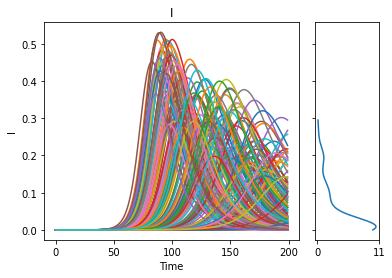

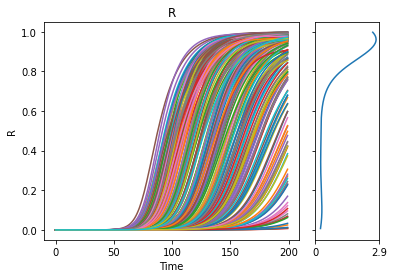

In [ ]:
from ema_workbench.analysis import plotting, plotting_util

#show lines, and end state density
for outcometoshow in ['I', 'R']:
  figure=plotting.lines(experiments, outcomes, outcomes_to_show=outcometoshow, density=plotting_util.Density.KDE) 



[MainProcess/INFO] Rinf not shown because it is not time series data
[MainProcess/INFO] Rinf not shown because it is not time series data


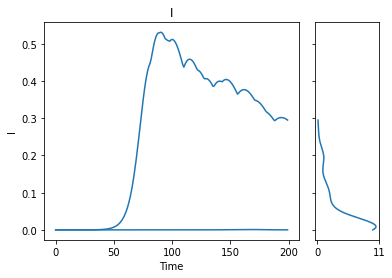

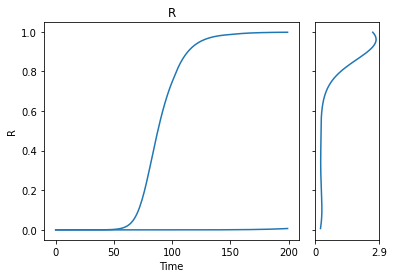

In [ ]:
#
# Show ENVELOPES, and end state density
# An envelope shows over time the minimum and maximum value for a set of runs over time.
#

for outcometoshow in ['I', 'R']:
  figure = plotting.envelopes(experiments, outcomes, outcomes_to_show=outcometoshow,density=plotting_util.Density.KDE)

## Visual Analysis
A key element in exploratory modeling is to try to understand how points in the uncertainty space map to outcomes or types of outcomes. Since in this example, we only have 2 uncertain parameters, basic visual inspection can give a fair bit of insight. Let's try to answer the following question: how do $\gamma$ and $\beta$ affect the severity and timing of the outbreak? To answer this we need to do the following:

1. Max_I
  * Get the maximum value over time for I for each scenario (use np.max)
  * Visualize how the max I is affected by $\beta$ and $\gamma$ jointly (use scatter plots with **max I** as color)
2. Time of maximum
  * Establish the point in time of this maximum (use np.argmax)
  * Visualize how the peak time is affected by $\beta$ and $\gamma$ jointly (use scatter plots with the **point in time** as color)
3. R_inf* (Recall that we have already got this as an outcome)
  * Visualize how 1 is affected by $\beta$ and $\gamma$ jointly (use scatter plots with the **point in time** as color)
4. Other questions
  * How are timing and the maximum related to each other?
  * How are timing, maximum and Rinf related with each other?

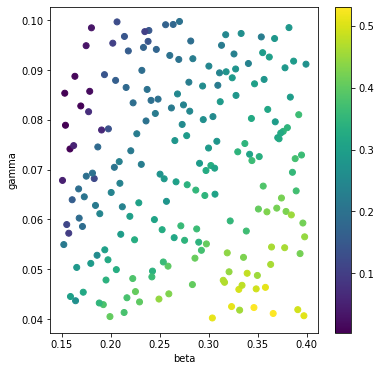

In [ ]:
I = outcomes['I']
maxI = np.max(I, axis=1)

fig, ax = plt.subplots(figsize=(6,6))

sc = ax.scatter(experiments.beta, experiments.gamma, c=maxI)
plt.colorbar(sc)
ax.set_xlabel('beta')
ax.set_ylabel('gamma')
plt.show()

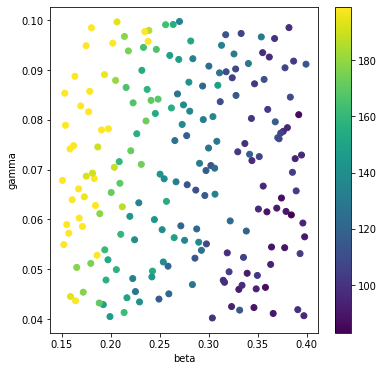

In [ ]:
I = outcomes['I']
timing = np.argmax(I, axis=1)

fig, ax = plt.subplots(figsize=(6,6))

sc = ax.scatter(experiments.beta, experiments.gamma, c=timing, cmap='viridis')
plt.colorbar(sc)
ax.set_xlabel('beta')
ax.set_ylabel('gamma')
plt.show()

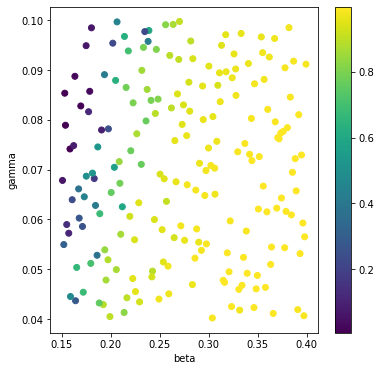

In [ ]:
fig, ax = plt.subplots(figsize=(6,6))

sc = ax.scatter(experiments.beta, experiments.gamma, c=outcomes['Rinf'], cmap='viridis')
plt.colorbar(sc)
ax.set_xlabel('beta')
ax.set_ylabel('gamma')
plt.show()

###Histograms of scalar outcomes

We can also plot the Scalar outcomes. Remeber that scalar outcomes are one value per scenario. Hence for 200 scenarios we will have that many outcome values.  We can do basic histograms or density fitting to see the distribution of the output.

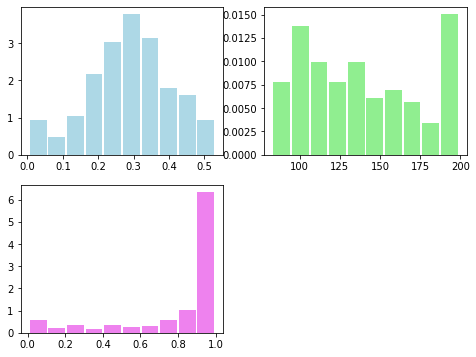

In [ ]:
#We can also plot the outcomes
fig = plt.figure(figsize=(8, 6))

# Adds subplot on position 1
ax = fig.add_subplot(221)
# Adds subplot on position 2
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)

# The maxI and timing are computed in earlier cells
ax.hist(maxI, density=True, rwidth=0.9, label='maxI', color='lightblue')
ax2.hist(timing, density=True, rwidth=0.9, label='peaktime', color='lightgreen')
ax3.hist(outcomes['Rinf'], density=True, rwidth=0.9, label='Rinf', color='violet')
plt.show()


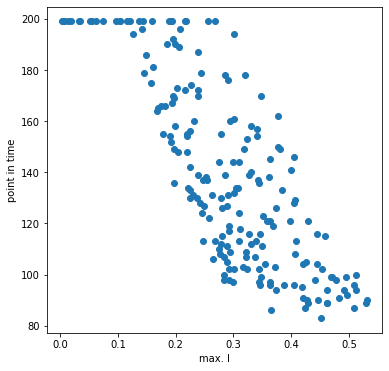

In [ ]:
fig, ax = plt.subplots(figsize=(6,6))

sc = ax.scatter(maxI, timing)
ax.set_xlabel('max. I')
ax.set_ylabel('point in time')
plt.show()

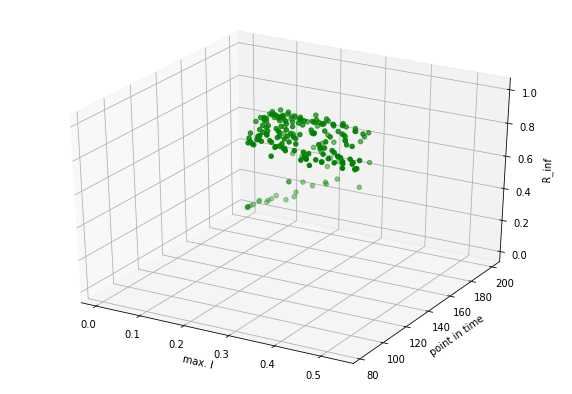

In [ ]:

# Creating figure
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")

ax.scatter3D(maxI, timing, outcomes['Rinf'], color="green")
ax.set_xlabel('max. I')
ax.set_ylabel('point in time')
ax.set_zlabel('R_inf')

plt.show()